In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import random


Starting striatum network simulation...
Simulating reward and punishment scenarios...
Applying reward at t=49.9
Applying reward at t=50.0
Resetting to baseline at t=100.0
Resetting to baseline at t=100.1
Applying punishment/no reward at t=150.0
Applying punishment/no reward at t=150.1
Resetting to baseline at t=200.0
Resetting to baseline at t=200.1


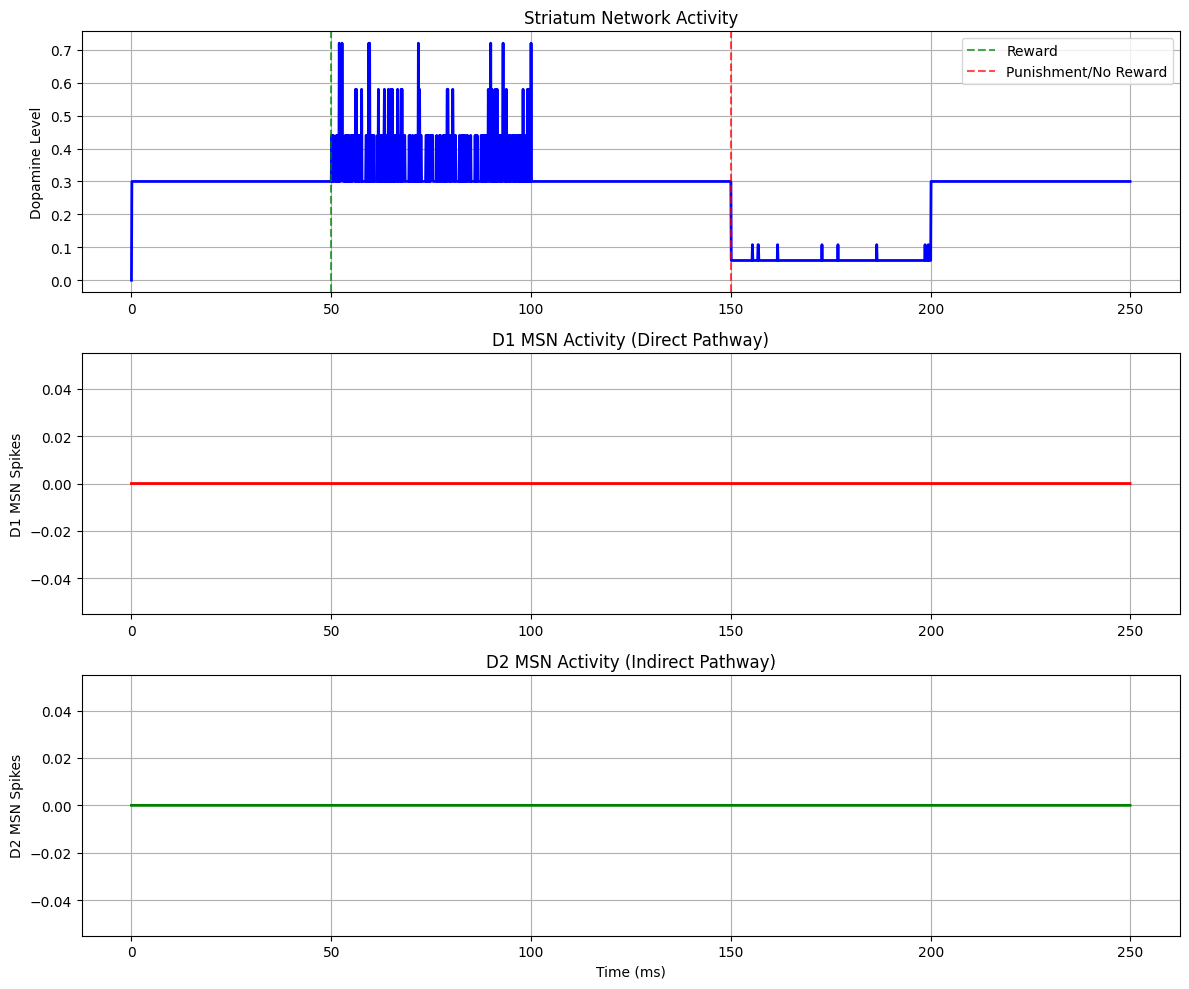


Simulation completed!
Average dopamine level: 0.264
Peak dopamine level: 0.720
Average D1 activity: 0.00 spikes/step
Average D2 activity: 0.00 spikes/step


In [ ]:

class Neuron:
    """Base neuron class with integrate-and-fire dynamics"""
    def __init__(self, name: str, threshold: float = -50.0, reset: float = -70.0, 
                 rest: float = -70.0, tau: float = 10.0):     # create array instead of single numbers floats
        self.name = name
        self.threshold = threshold
        self.reset = reset
        self.rest = rest
        self.tau = tau
        self.membrane_potential = rest
        self.spike_times = []  # 2-d array(neuron,time)
        self.current_input = 0.0
        self.last_spike_time = -np.inf
        
    def update(self, dt: float, input_current: float = 0.0):
        """Update neuron state using Euler integration"""
        self.current_input = input_current
        
        # Integrate-and-fire dynamics
        dv = (-(self.membrane_potential - self.rest) + input_current) / self.tau
        self.membrane_potential += dv * dt
        
        # Check for spike
        if self.membrane_potential >= self.threshold:  # save it and use it an Boolean index to reset
            self.spike_times.append(self.last_spike_time)
            self.last_spike_time = 0.0  # Reset spike timer
            self.membrane_potential = self.reset
            return True
        return False
    
    def reset_neuron(self):
        """Reset neuron to resting state"""
        self.membrane_potential = self.rest
        self.spike_times = []
        self.last_spike_time = -np.inf

class DopamineNeuron(Neuron):
    """VTA Dopamine neuron with baseline and burst modes"""
    def __init__(self, name: str):
        super().__init__(name, threshold=-45.0, rest=-65.0) # super = neuron
        self.baseline_rate = 0.1  # Baseline firing rate
        self.burst_mode = False
        self.dopamine_release = 0.0
        
    def set_burst_mode(self, burst: bool):
        """Set burst firing mode for reward signaling"""
        self.burst_mode = burst
        
    def update(self, dt: float, input_current: float = 0.0):
        """Update with dopamine-specific dynamics"""
        if self.burst_mode:
            # Higher firing rate during burst
            firing_rate = 0.8
        else:
            # Baseline firing rate
            firing_rate = self.baseline_rate
            
        # Add stochastic firing
        if random.random() < firing_rate * dt:
            self.dopamine_release = 1.0 if self.burst_mode else 0.3
            return super().update(dt, input_current + 15.0)
        
        # Set dopamine release based on baseline rate (lower rate = lower dopamine)
        self.dopamine_release = max(0.05, self.baseline_rate * 3.0)  # Scale baseline to dopamine
        return super().update(dt, input_current)

class MSNeuron(Neuron):
    """Medium Spiny Neuron (D1 or D2 type)"""
    def __init__(self, name: str, receptor_type: str):
        super().__init__(name, threshold=-40.0, rest=-80.0)
        self.receptor_type = receptor_type  # 'D1' or 'D2'
        self.dopamine_sensitivity = 1.0
        
    def dopamine_response(self, dopamine_level: float):
        """Calculate response to dopamine based on receptor type"""
        if self.receptor_type == 'D1':
            # D1 receptors: activated by high dopamine (burst)
            if dopamine_level > 0.6:  # Higher threshold for burst detection
                return 20.0  # Strong excitatory response
            else:
                return -2.0  # Slightly inhibited at baseline
        else:  # D2
            # D2 receptors: inhibited by baseline dopamine
            if dopamine_level > 0.15:  # Lower threshold for baseline detection
                return -20.0  # Strong inhibitory response
            else:
                return 15.0  # Strongly disinhibited when dopamine drops

class GABANeuron(Neuron):
    """GABA inhibitory neuron"""
    def __init__(self, name: str, location: str):
        super().__init__(name, threshold=-45.0, rest=-65.0)
        self.location = location  # 'VTA' or 'VP'

class Synapse:
    """Synapse with STDP"""
    def __init__(self, pre_neuron: Neuron, post_neuron: Neuron, 
                 weight: float = 0.5, delay: float = 1.0):
        self.pre_neuron = pre_neuron
        self.post_neuron = post_neuron
        self.weight = weight
        self.delay = delay
        self.spike_buffer = []  # Buffer for delayed spikes
        
        # STDP parameters
        self.A_plus = 0.01  # LTP amplitude
        self.A_minus = -0.01  # LTD amplitude
        self.tau_plus = 20.0  # LTP time constant
        self.tau_minus = 20.0  # LTD time constant
        
    def update_stdp(self, dt: float):
        """Update synaptic weight using STDP"""
        if len(self.pre_neuron.spike_times) == 0 or len(self.post_neuron.spike_times) == 0:
            return
            
        # Get recent spikes
        pre_spikes = self.pre_neuron.spike_times[-5:]  # Last 5 spikes
        post_spikes = self.post_neuron.spike_times[-5:]  # Last 5 spikes
        
        weight_change = 0.0
        
        for pre_time in pre_spikes:
            for post_time in post_spikes:
                dt_spike = post_time - pre_time
                
                if dt_spike > 0:  # Post before pre (LTP)
                    weight_change += self.A_plus * np.exp(-dt_spike / self.tau_plus)
                elif dt_spike < 0:  # Pre before post (LTD)
                    weight_change += self.A_minus * np.exp(dt_spike / self.tau_minus)
        
        self.weight += weight_change
        self.weight = np.clip(self.weight, 0.0, 2.0)  # Bound weights
        
    def transmit(self, spike: bool, current_time: float):
        """Transmit spike through synapse with delay"""
        if spike:
            self.spike_buffer.append(current_time + self.delay)
        
        # Check for delayed spikes
        transmitted_spikes = []
        for spike_time in self.spike_buffer:
            if current_time >= spike_time:
                transmitted_spikes.append(spike_time)
        
        # Remove transmitted spikes from buffer
        for spike_time in transmitted_spikes:
            self.spike_buffer.remove(spike_time)
        
        return len(transmitted_spikes) * self.weight

class StriatumNetwork:
    """Complete striatum network model"""
    def __init__(self):
        self.time = 0.0
        self.dt = 0.1
        
        # Create neurons
        self.vta_da_neurons = [DopamineNeuron(f'VTA_DA_{i}') for i in range(5)]
        self.vta_gaba_neurons = [GABANeuron(f'VTA_GABA_{i}', 'VTA') for i in range(3)]
        self.vp_gaba_neurons = [GABANeuron(f'VP_GABA_{i}', 'VP') for i in range(3)]
        
        # D1 and D2 MSNs
        self.d1_msns = [MSNeuron(f'D1_MSN_{i}', 'D1') for i in range(10)]
        self.d2_msns = [MSNeuron(f'D2_MSN_{i}', 'D2') for i in range(10)]
        
        # Create synapses
        self.synapses = []
        self.create_connections()
        
        # Recording variables
        self.dopamine_history = []
        self.d1_activity = []
        self.d2_activity = []
        self.time_history = []
        
    def create_connections(self):
        """Create synaptic connections"""
        # VTA DA -> MSNs (dopaminergic input)
        for da_neuron in self.vta_da_neurons:
            for d1_msn in self.d1_msns:
                self.synapses.append(Synapse(da_neuron, d1_msn, weight=0.8))
            for d2_msn in self.d2_msns:
                self.synapses.append(Synapse(da_neuron, d2_msn, weight=0.8))
        
        # D1 MSNs -> VTA GABA (inhibitory)
        for d1_msn in self.d1_msns[:5]:  # First half to VTA
            for vta_gaba in self.vta_gaba_neurons:
                self.synapses.append(Synapse(d1_msn, vta_gaba, weight=1.2))
        
        # D1 MSNs -> VP GABA (inhibitory)
        for d1_msn in self.d1_msns[5:]:  # Second half to VP
            for vp_gaba in self.vp_gaba_neurons:
                self.synapses.append(Synapse(d1_msn, vp_gaba, weight=1.2))
        
        # D2 MSNs -> VP GABA (inhibitory)
        for d2_msn in self.d2_msns:
            for vp_gaba in self.vp_gaba_neurons:
                self.synapses.append(Synapse(d2_msn, vp_gaba, weight=1.0))
        
        # VTA GABA -> VTA DA (inhibitory)
        for vta_gaba in self.vta_gaba_neurons:
            for vta_da in self.vta_da_neurons:
                self.synapses.append(Synapse(vta_gaba, vta_da, weight=1.5))
        
        # VP GABA -> VTA GABA (inhibitory)
        for vp_gaba in self.vp_gaba_neurons:
            for vta_gaba in self.vta_gaba_neurons:
                self.synapses.append(Synapse(vp_gaba, vta_gaba, weight=1.3))
    
    def calculate_dopamine_level(self):
        """Calculate current dopamine level in striatum"""
        total_release = sum(neuron.dopamine_release for neuron in self.vta_da_neurons)
        return total_release / len(self.vta_da_neurons)
    
    def apply_reward(self, reward_strength: float = 1.0):
        """Apply reward signal (dopamine burst)"""
        for neuron in self.vta_da_neurons:
            neuron.set_burst_mode(True)
    
    def apply_punishment_or_no_reward(self):
        """Apply punishment/no reward (dopamine dip)"""
        for neuron in self.vta_da_neurons:
            neuron.baseline_rate = 0.02  # Significant reduction in baseline
            neuron.set_burst_mode(False)
    
    def reset_dopamine_system(self):
        """Reset dopamine system to baseline"""
        for neuron in self.vta_da_neurons:
            neuron.baseline_rate = 0.1
            neuron.set_burst_mode(False)
    
    def update_network(self):
        """Update entire network for one time step"""
        # Calculate current dopamine level
        dopamine_level = self.calculate_dopamine_level()
        
        # Collect all neurons
        all_neurons = (self.vta_da_neurons + self.vta_gaba_neurons + 
                      self.vp_gaba_neurons + self.d1_msns + self.d2_msns)
        
        # Update each neuron
        spikes = {}
        for neuron in all_neurons:
            # Calculate synaptic input
            synaptic_input = 0.0
            
            # Find synapses targeting this neuron
            for synapse in self.synapses:
                if synapse.post_neuron == neuron:
                    # Check if presynaptic neuron spiked
                    pre_spike = (synapse.pre_neuron in spikes and 
                               spikes[synapse.pre_neuron])
                    transmitted = synapse.transmit(pre_spike, self.time)
                    
                    # Apply inhibitory/excitatory effects
                    if isinstance(synapse.pre_neuron, (MSNeuron, GABANeuron)):
                        synaptic_input -= transmitted  # Inhibitory
                    else:
                        synaptic_input += transmitted  # Excitatory
            
            # Add dopamine modulation for MSNs
            if isinstance(neuron, MSNeuron):
                dopamine_input = neuron.dopamine_response(dopamine_level)
                synaptic_input += dopamine_input
            
            # Update neuron
            spike = neuron.update(self.dt, synaptic_input)
            spikes[neuron] = spike
        
        # Update STDP for all synapses
        for synapse in self.synapses:
            synapse.update_stdp(self.dt)
        
        # Record data
        self.dopamine_history.append(dopamine_level)
        self.d1_activity.append(sum(1 for n in self.d1_msns if spikes.get(n, False)))
        self.d2_activity.append(sum(1 for n in self.d2_msns if spikes.get(n, False)))
        self.time_history.append(self.time)
        
        self.time += self.dt
    
    def simulate(self, duration: float):
        """Run simulation for specified duration"""
        steps = int(duration / self.dt)
        
        for step in range(steps):
            self.update_network()
            
            # Example scenario: reward at t=50, punishment at t=150
            if abs(self.time - 50.0) < self.dt:
                print(f"Applying reward at t={self.time:.1f}")
                self.apply_reward()
            elif abs(self.time - 100.0) < self.dt:
                print(f"Resetting to baseline at t={self.time:.1f}")
                self.reset_dopamine_system()
            elif abs(self.time - 150.0) < self.dt:
                print(f"Applying punishment/no reward at t={self.time:.1f}")
                self.apply_punishment_or_no_reward()
            elif abs(self.time - 200.0) < self.dt:
                print(f"Resetting to baseline at t={self.time:.1f}")
                self.reset_dopamine_system()
    
    def plot_results(self):
        """Plot simulation results"""
        fig, axes = plt.subplots(3, 1, figsize=(12, 10))
        
        # Plot dopamine levels
        axes[0].plot(self.time_history, self.dopamine_history, 'b-', linewidth=2)
        axes[0].set_ylabel('Dopamine Level')
        axes[0].set_title('Striatum Network Activity')
        axes[0].grid(True)
        axes[0].axvline(x=50, color='g', linestyle='--', alpha=0.7, label='Reward')
        axes[0].axvline(x=150, color='r', linestyle='--', alpha=0.7, label='Punishment/No Reward')
        axes[0].legend()
        
        # Plot D1 MSN activity
        axes[1].plot(self.time_history, self.d1_activity, 'r-', linewidth=2)
        axes[1].set_ylabel('D1 MSN Spikes')
        axes[1].set_title('D1 MSN Activity (Direct Pathway)')
        axes[1].grid(True)
        
        # Plot D2 MSN activity
        axes[2].plot(self.time_history, self.d2_activity, 'g-', linewidth=2)
        axes[2].set_ylabel('D2 MSN Spikes')
        axes[2].set_xlabel('Time (ms)')
        axes[2].set_title('D2 MSN Activity (Indirect Pathway)')
        axes[2].grid(True)
        
        plt.tight_layout()
        plt.show()


Starting striatum network simulation...
Simulating reward and punishment scenarios...
Applying reward at t=49.9
Applying reward at t=50.0
Resetting to baseline at t=100.0
Resetting to baseline at t=100.1
Applying punishment/no reward at t=150.0
Applying punishment/no reward at t=150.1
Resetting to baseline at t=200.0
Resetting to baseline at t=200.1


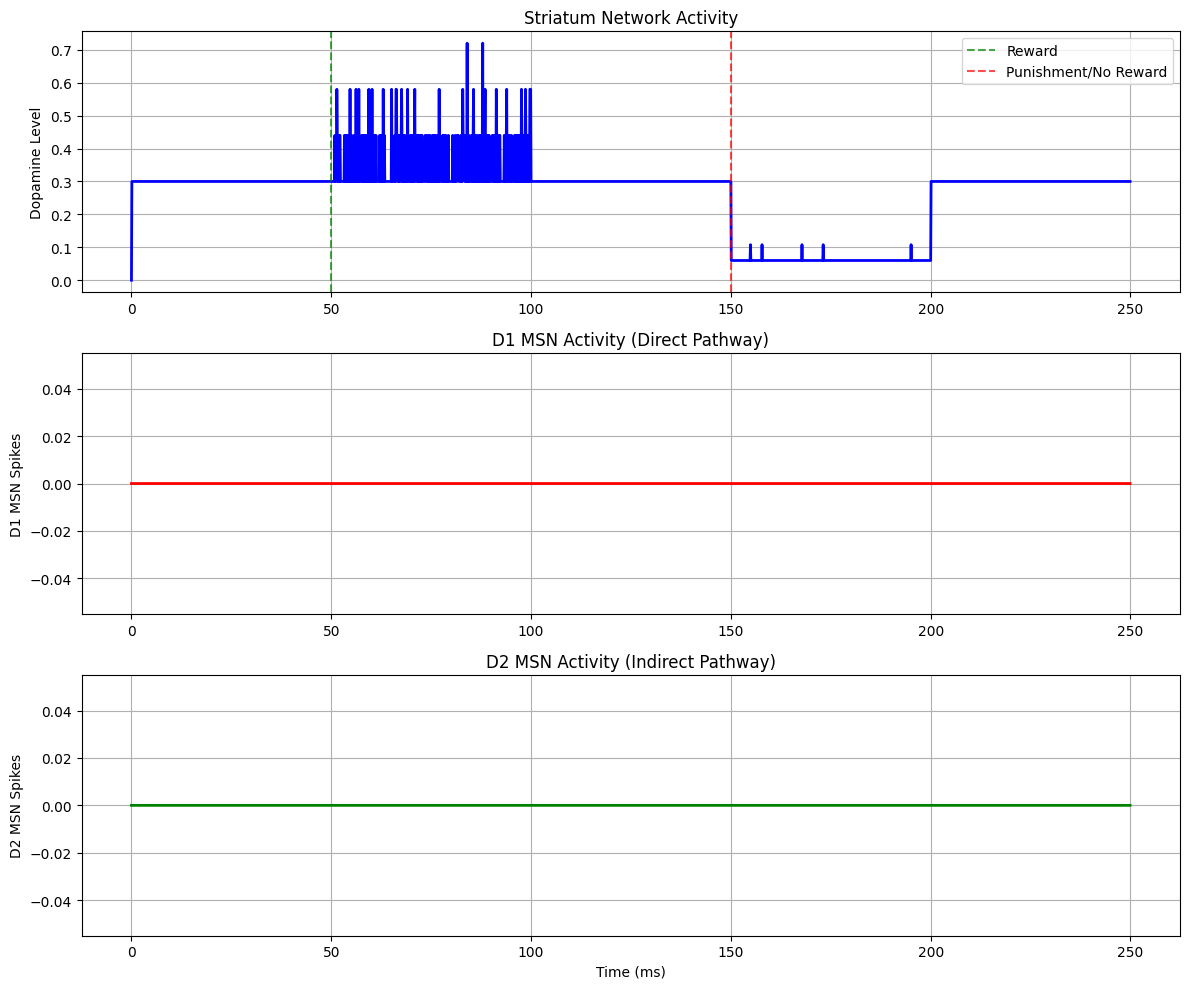


Simulation completed!
Average dopamine level: 0.263
Peak dopamine level: 0.720
Average D1 activity: 0.00 spikes/step
Average D2 activity: 0.00 spikes/step


In [3]:

# Example usage
if __name__ == "__main__":
    # Create and run the network
    network = StriatumNetwork()
    print("Starting striatum network simulation...")
    print("Simulating reward and punishment scenarios...")
    
    # Run simulation
    network.simulate(duration=250.0)  # 250ms simulation
    
    # Plot results
    network.plot_results()
    
    # Print some statistics
    print(f"\nSimulation completed!")
    print(f"Average dopamine level: {np.mean(network.dopamine_history):.3f}")
    print(f"Peak dopamine level: {np.max(network.dopamine_history):.3f}")
    print(f"Average D1 activity: {np.mean(network.d1_activity):.2f} spikes/step")
    print(f"Average D2 activity: {np.mean(network.d2_activity):.2f} spikes/step")